In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blk1804/kiba-drug-binding-dataset")

print("Path to dataset files:", path)


Path to dataset files: /home/marci/.cache/kagglehub/datasets/blk1804/kiba-drug-binding-dataset/versions/1


In [8]:
import pandas as pd

# Assuming the CSV file is named 'data.csv' in the provided path
csv_path = f"{path}/KIBA.csv"
df = pd.read_csv(csv_path)
print(df.head())

       CHEMBLID ProteinID                                compound_iso_smiles  \
0  CHEMBL373751    P53350  COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...   
1  CHEMBL373751    P00533  COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...   
2  CHEMBL373751    P04626  COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...   
3  CHEMBL373751    P49840  COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...   
4  CHEMBL373751    P49841  COC1=C(C=C2C(=C1)N=CN2C3=CC(=C(S3)C#N)OCC4=CC=...   

                                     target_sequence  \
0  MSAAVTAGKLARAPADPGKAGVPGVAAPGAPAAAPPAKEIPEVLVD...   
1  MRPSGTAGAALLALLAALCPASRALEEKKVCQGTSNKLTQLGTFED...   
2  MELAALCRWGLLLALLPPGAASTQVCTGTDMKLRLPASPETHLDML...   
3  MSGGGPSGGGPGGSGRARTSSFAEPGGGGGGGGGGPGGSASGPGGT...   
4  MSGRPRTTSFAESCKPVQQPSAFGSMKVSRDKDGSKVTTVVATPGQ...   

   Ki , Kd and IC50  (KIBA Score)  
0                             0.0  
1                             1.1  
2                             1.1  
3                             1.3  
4 

In [9]:
# Rename the last column to 'interaction'
df.rename(columns={'Ki , Kd and IC50  (KIBA Score)': 'interaction'}, inplace=True)
df.rename(columns={'compound_iso_smiles': 'smiles'}, inplace=True)

# Show the distribution of the 'interaction' column
interaction_distribution = df['interaction'].describe()
print(interaction_distribution)

count    118254.000000
mean         11.719935
std           0.836947
min           0.000000
25%          11.200000
50%          11.500000
75%          11.923909
max          17.200180
Name: interaction, dtype: float64


In [10]:
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit import DataStructs
import numpy as np

def smiles_to_maccs_fp(smiles_list):
    fingerprints = []
    
    # MACCS keys produce a 167-bit fingerprint.
    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            fp = MACCSkeys.GenMACCSKeys(mol)
            arr = np.zeros((167,), dtype=np.int8)
            DataStructs.ConvertToNumpyArray(fp, arr)
            fingerprints.append(arr)
        else:
            fingerprints.append(np.zeros(167, dtype=np.int8))
    
    return np.array(fingerprints)
def process_smiles_in_batches(smiles_list, batch_size=1000):
    all_fingerprints = []
    
    # Process in batches
    for i in range(0, len(smiles_list), batch_size):
        batch = smiles_list[i:i+batch_size]
        batch_fps = smiles_to_maccs_fp(batch)
        all_fingerprints.append(batch_fps)
        
        
    # Combine results
    return np.vstack(all_fingerprints)

In [11]:
def protein_feature_hashing(protein_sequences, n_features=1000, batch_size=1000):
    from sklearn.feature_extraction.text import HashingVectorizer
    
    all_encodings = []
    vectorizer = HashingVectorizer(n_features=n_features, analyzer='char', ngram_range=(3, 3))
    
    for i in range(0, len(protein_sequences), batch_size):
        batch = protein_sequences[i:i+batch_size]
        encodings = vectorizer.transform(batch).toarray()
        all_encodings.append(encodings)
        
    
    return np.vstack(all_encodings)

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Combine feature sets
X_compounds = process_smiles_in_batches(df['smiles'])
print("compounds encoded")
X_proteins = protein_feature_hashing(df['target_sequence'])
print("proteins encoded")

# You can concatenate the features
X = np.hstack((X_compounds, X_proteins))
y = df['interaction']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
print(f"R2: {r2_score(y_test, y_pred)}")

# Feature importance for interpretability
feature_importances = model.feature_importances_

compounds encoded
proteins encoded
RMSE: 0.5223641531947705
R2: 0.6043449036109867


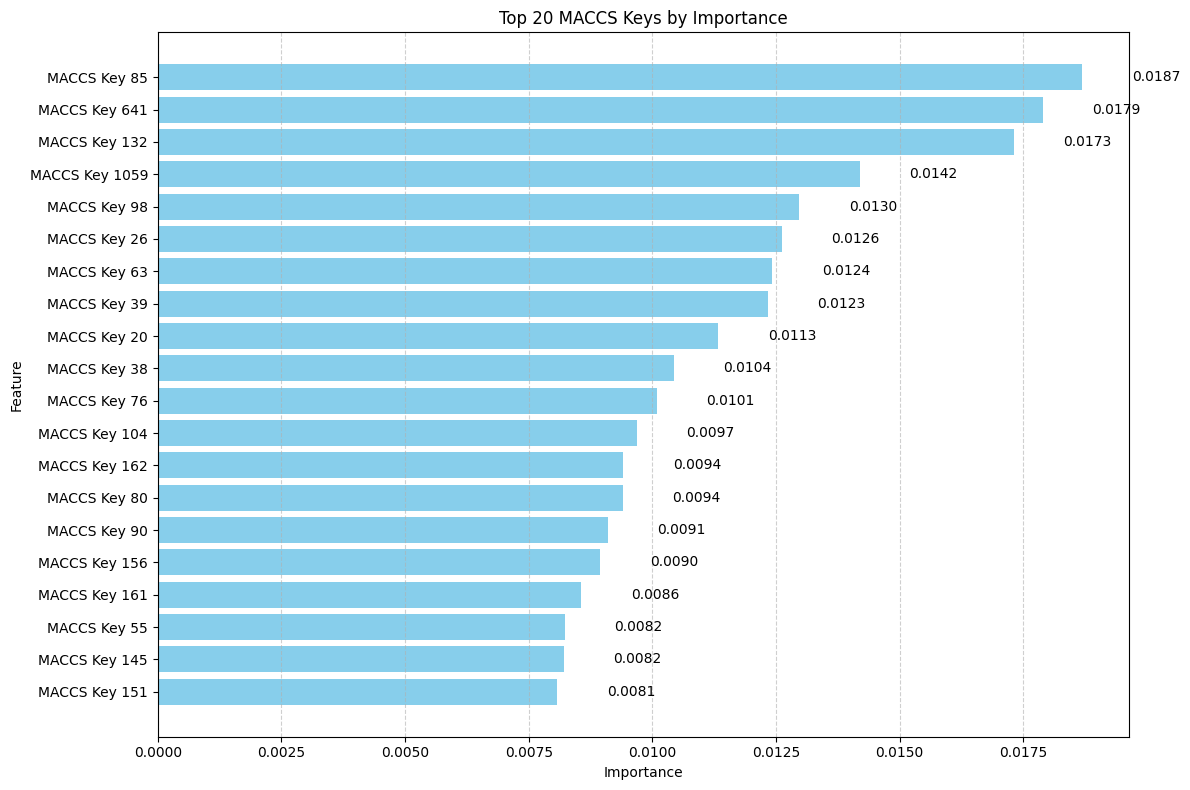

,MACCS Key Index,Importance
0,85,0.018693
1,641,0.017890
2,132,0.017312
3,1059,0.014191
4,98,0.012974
5,26,0.012623
6,63,0.012429
7,39,0.012340
8,20,0.011336
9,38,0.010440


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_top_features(model, n_features=20, figsize=(12, 8)):
    """
    Plot the top n_features by importance from a model.
    
    Parameters:
    -----------
    model : model with feature_importances_ attribute
        Trained model like RandomForest, GradientBoosting, etc.
    n_features : int
        Number of top features to show
    figsize : tuple
        Figure size
    """
    # Get feature importances
    importances = model.feature_importances_
    
    # Create indices array for features
    indices = np.argsort(importances)[::-1]
    
    # Take the top n features
    top_indices = indices[:n_features]
    top_importances = importances[top_indices]
    
    # Create labels for MACCS keys
    # MACCS keys are numbered 1-166 in RDKit, but we use 0-indexed arrays
    labels = [f"MACCS Key {idx+1}" for idx in top_indices]
    
    # Create DataFrame for easier plotting
    df_plot = pd.DataFrame({
        'Feature': labels,
        'Importance': top_importances
    }).sort_values('Importance')
    
    # Create horizontal bar chart
    plt.figure(figsize=figsize)
    plt.barh(df_plot['Feature'], df_plot['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Top {n_features} MACCS Keys by Importance')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    
    # Add importance values as text
    for i, v in enumerate(df_plot['Importance']):
        plt.text(v + 0.001, i, f'{v:.4f}', va='center')
    
    plt.tight_layout()
    plt.show()
    
    # Return the top indices and their importances
    return pd.DataFrame({
        'MACCS Key Index': [idx+1 for idx in top_indices],  # 1-indexed for MACCS keys
        'Importance': top_importances
    }).sort_values('Importance', ascending=False)
plot_top_features(model)